In [1]:
import numpy as np
from astropy.cosmology import Planck13
from matplotlib.pyplot import *
import itertools

In [2]:
def get_lsfr_ratio(lmass, zred, lsfr):
    """
    We're modeling using a two-value star formation history, both of which are constant. 
    Prospector takes as input the log of the ratio of those two star formation rates. 
    We have the current star formation rate; we next have to find the 'old' star formation rate
        such that the total mass is what we want it to be. 
    This function does that algebra for us. 
    """
    # determine lsfr1 / lsfr2 = lsfr1 / lsfr

    # calculate sfr2
    sfr2 = 10 ** lsfr
    mass = 10 ** lmass

    # set time of most recent sfr in Gyrs
    t_sfr2 = 0.05

    t_sfr1 = Planck13.lookback_time(1000).value - Planck13.lookback_time(zred).value - t_sfr2
    sfr1 = (mass - (sfr2 * t_sfr2 * 1e9)) / (t_sfr1 * 1e9)

    # Since I was interested in plotting, I changed the `assert` here to instead generate a SFH where all the stars
    # formed very recently, allowing the function to shorten t_sfr2 such that mass = t_sfr2 * sfr2 and sfr1 = 0
    if sfr1 <= 0:
        t_sfr2 = mass / sfr2 * 1e-9
        t_sfr1 = Planck13.lookback_time(1000).value - Planck13.lookback_time(zred).value - t_sfr2
        sfr1 = 0
        mask = [False,True]
    else:
        mask = [True,True]

    return [t_sfr1, t_sfr2, sfr1, sfr2, mask[0], mask[1]]

In [13]:
lmasses = np.linspace(7,11.5,5)
zs = np.linspace(3,7,5)
lsfrs = np.linspace(-0.5,3,5)

# Data Grid of parameters
data_params = np.empty((len(lmasses),len(zs),len(lsfrs),3))

# Data Grid of star formation histories and time spent during each star formation rate
data_grid = np.empty((len(lmasses),len(zs),len(lsfrs),6))

for i_lmass,i_z,i_lsfr in itertools.product(range(len(lmasses)),range(len(zs)),range(len(lsfrs))):
    data = get_lsfr_ratio(lmasses[i_lmass],zs[i_z],lsfrs[i_lsfr])
    data_grid[i_lmass,i_z,i_lsfr,:] = data
    data_params[i_lmass,i_z,i_lsfr,:] = [lmasses[i_lmass], zs[i_z], lsfrs[i_lsfr]]

In [14]:
def getSfrPlot(grid, params):

    figure(figsize=(8,4))

    mass, zred, lsfr = params[0], params[1], params[2]
    
    t1,t2,sfr1,sfr2 = grid[0], grid[1], grid[2], grid[3]

    x1 = np.linspace(Planck13.lookback_time(1000).value, Planck13.lookback_time(zred).value+t2, 50)
    x2 = np.linspace(Planck13.lookback_time(zred).value+t2, Planck13.lookback_time(zred).value)

    y1 = np.ones(50) * sfr1
    y2 = np.ones(50) * sfr2

    sfrs = np.array([sfr1,sfr2])
    
    plot(x1,y1, color='lightblue')
    fill_between(x1, y1, color='lightblue', alpha=0.5, label=f'SFR1={sfr1:.2f}, t1={t1*1e9:.2e}')
    
    plot(x2,y2, color='orange')
    fill_between(x2, y2, color='orange', alpha=0.5, label=f'SFR2={sfr2:.2f}, t2={t2*1e9:.2e}')

    # Arrays used to plot a dashed line at the farthest possible lookback time
    x_lookback = np.ones(10)*Planck13.lookback_time(1000).value
    y_lookback = np.linspace(-1,1400,10)

    # Arrays used to plot a dashed line at the given redshift for the model
    x_redshift = np.ones(10)*Planck13.lookback_time(zred).value
    y_redshift = np.linspace(-1,1400,10)

    plot(x_lookback, y_lookback, color='black', alpha=0.7, ls='--', lw=0.5, label='Range of observable SFH')
    plot(x_redshift, y_redshift, color='black', alpha=0.7, ls='--', lw=0.5)

    xlim([Planck13.lookback_time(1000).value+.1,Planck13.lookback_time(zred).value-.1])
    ylim([0,sfrs.max()*1.2])

    title(f'lmass={mass}, zred={zred:.0f}')

    xlabel('Lookback Time (Gyrs)')
    ylabel(r'SFR ($M_{\odot}$/yr)')

    legend()
    

------------

/tmp/ipykernel_17211/2936734070.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure(figsize=(8,4))


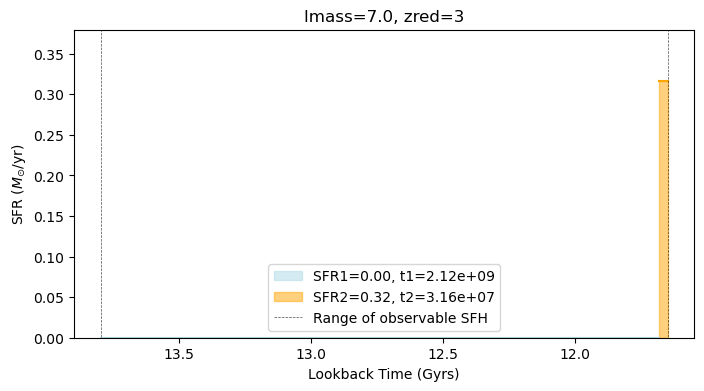

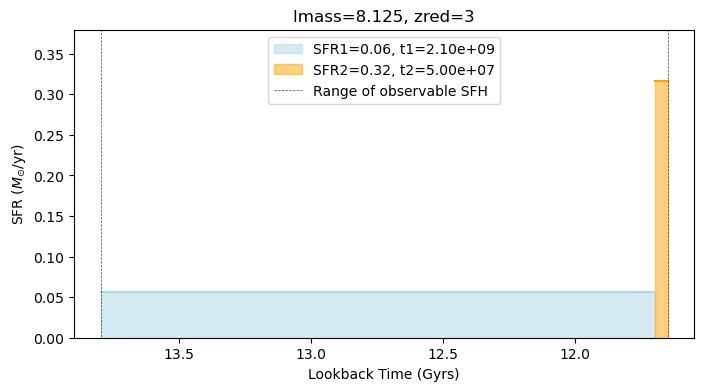

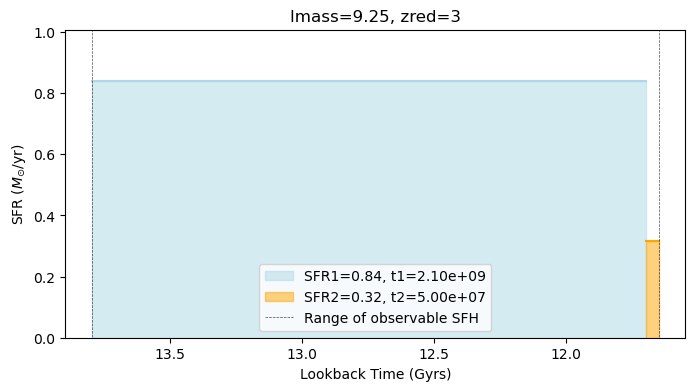

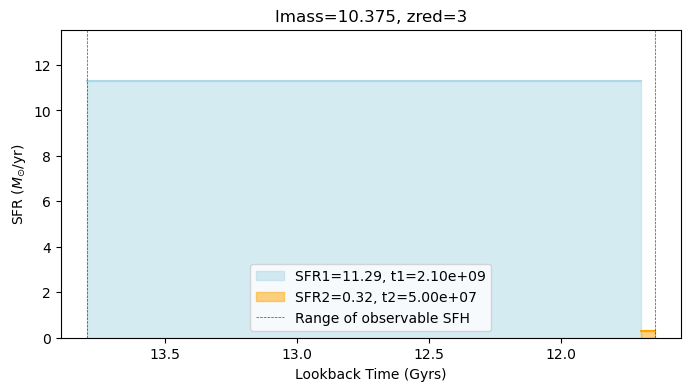

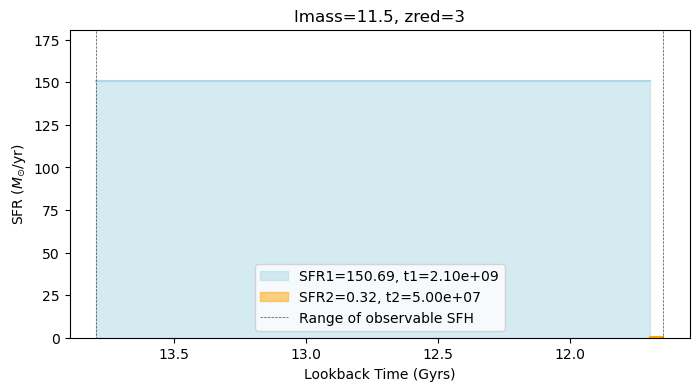

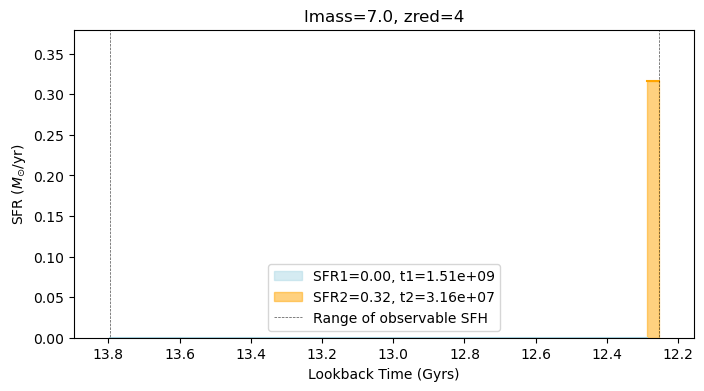

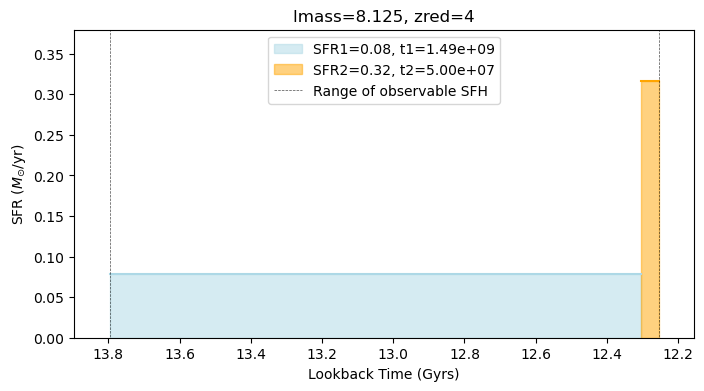

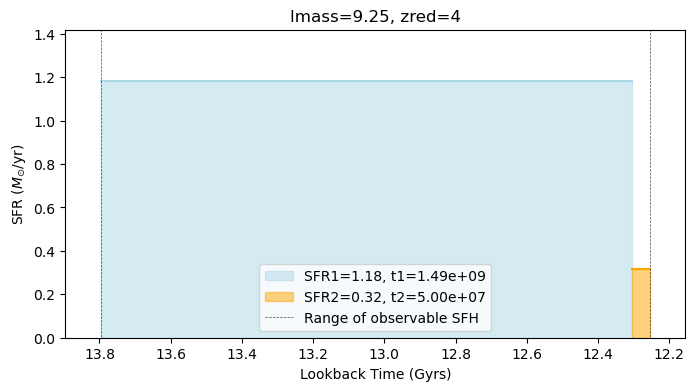

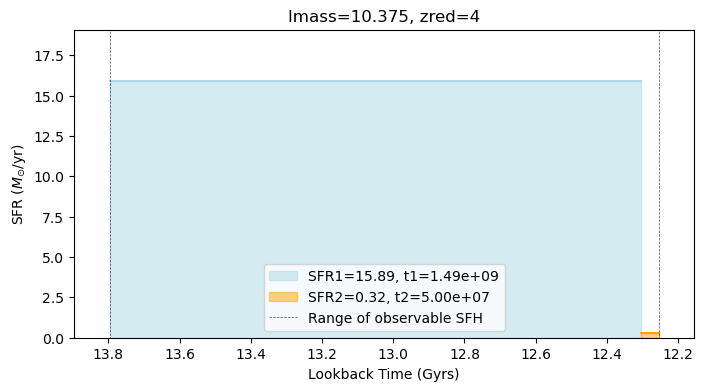

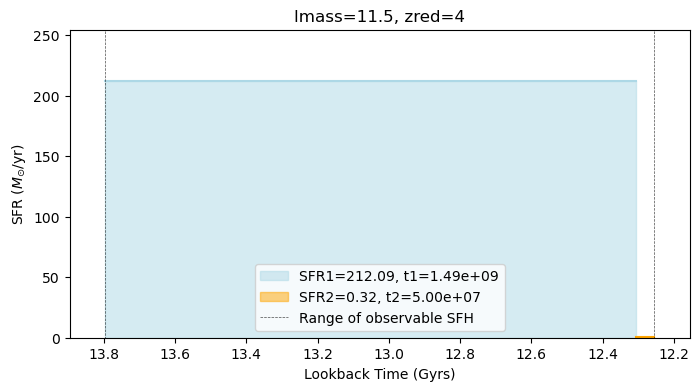

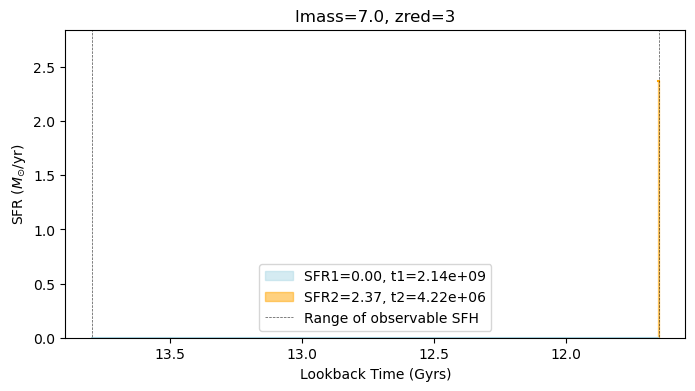

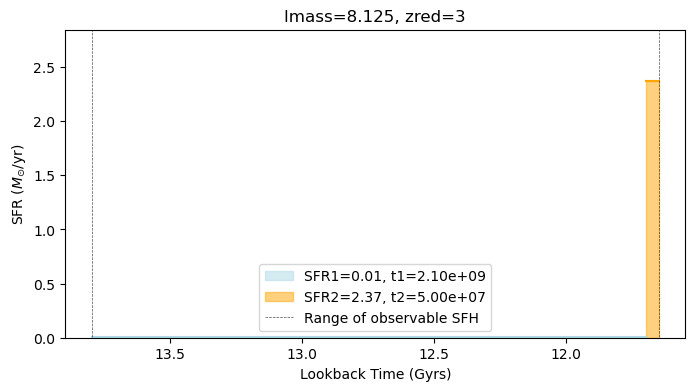

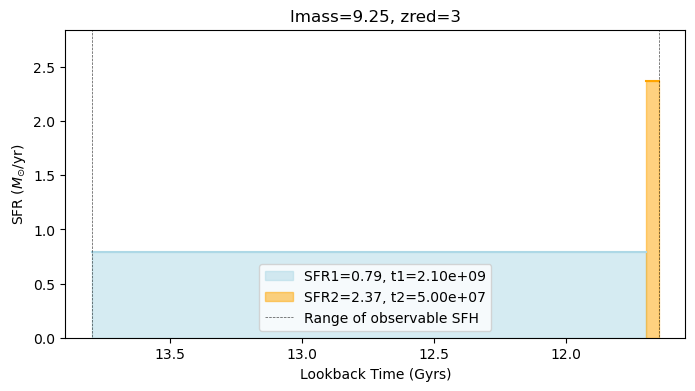

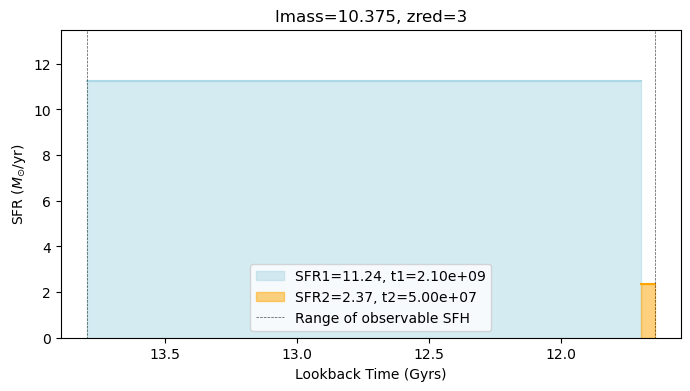

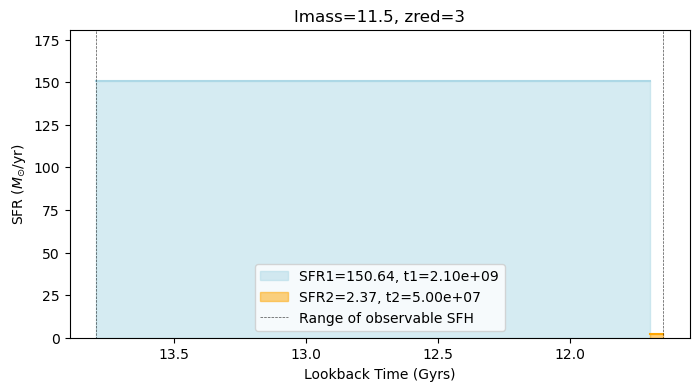

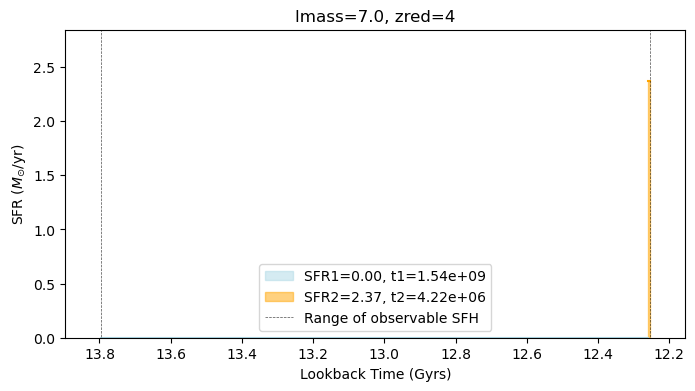

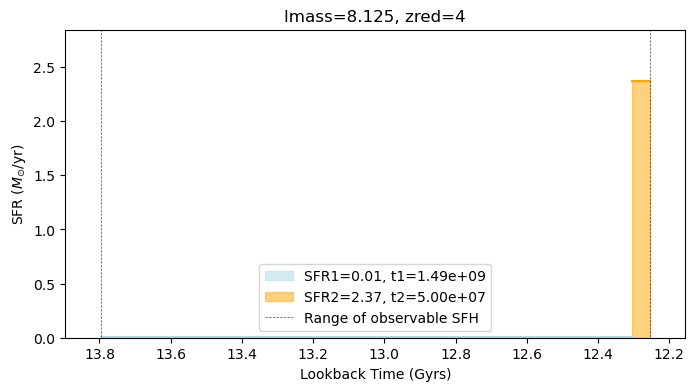

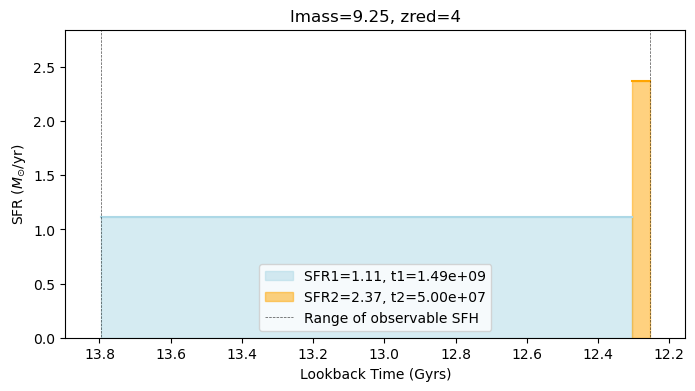

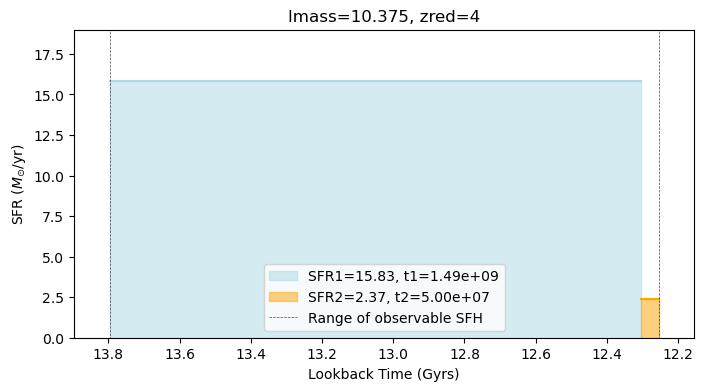

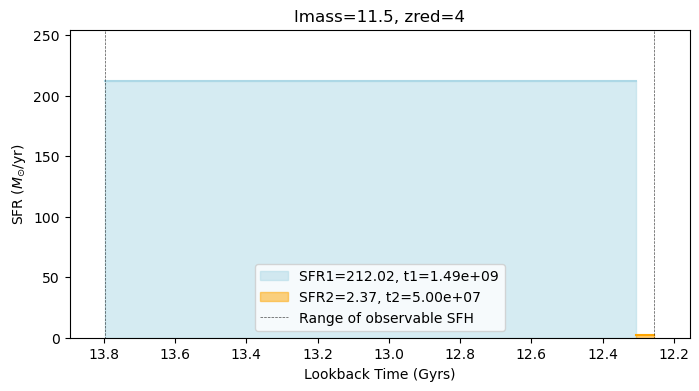

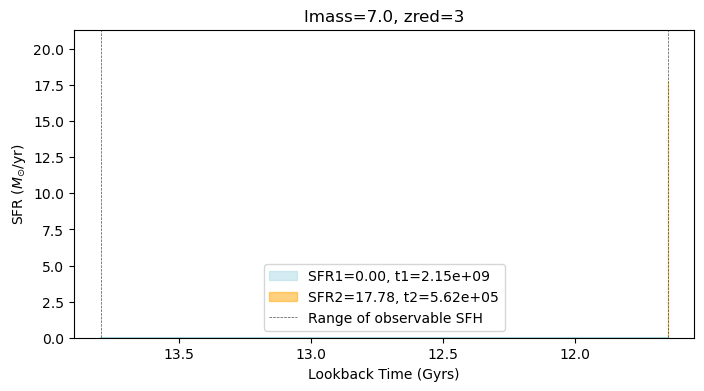

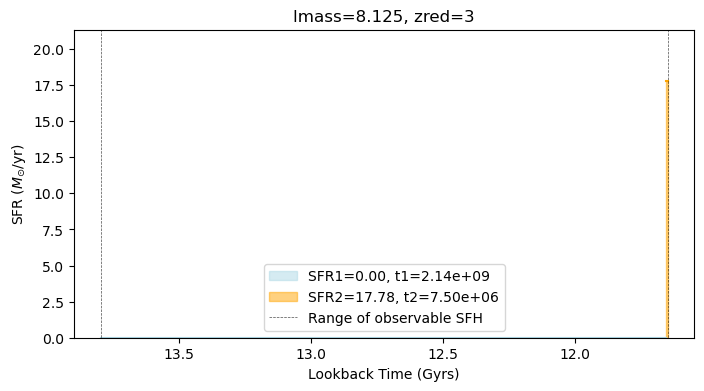

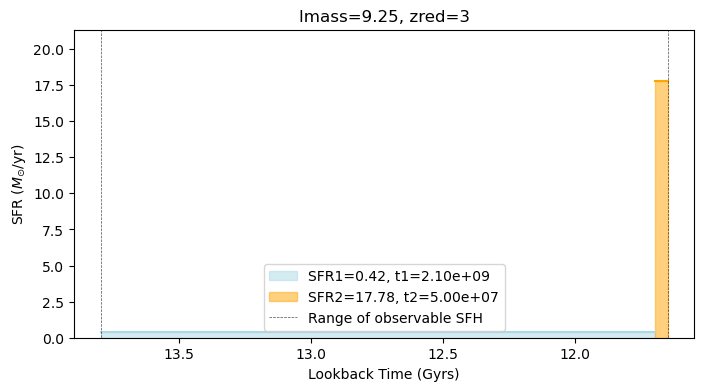

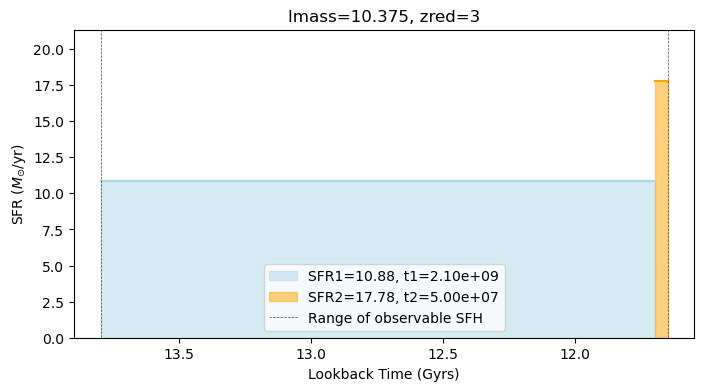

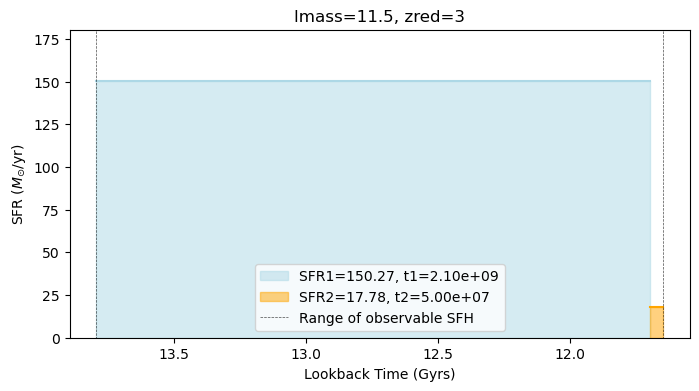

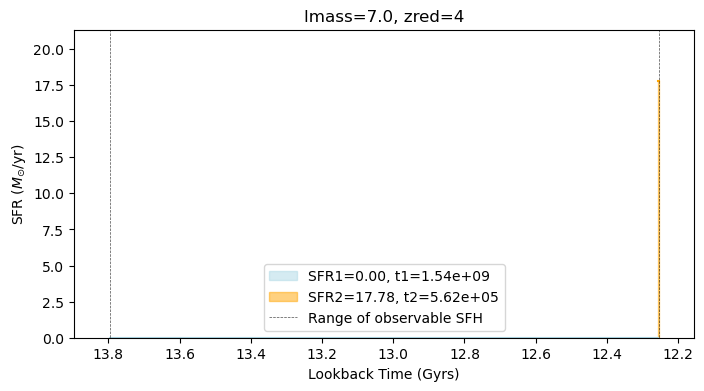

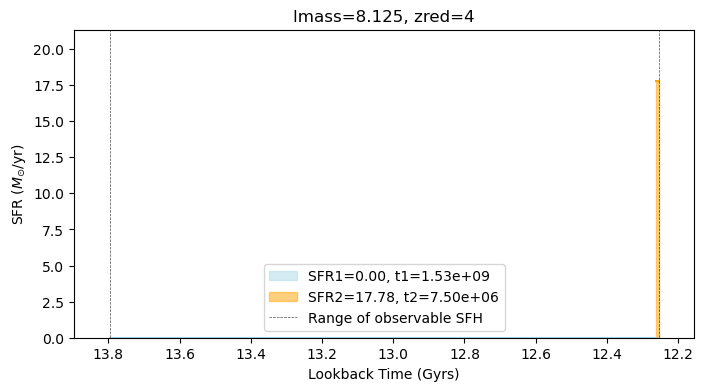

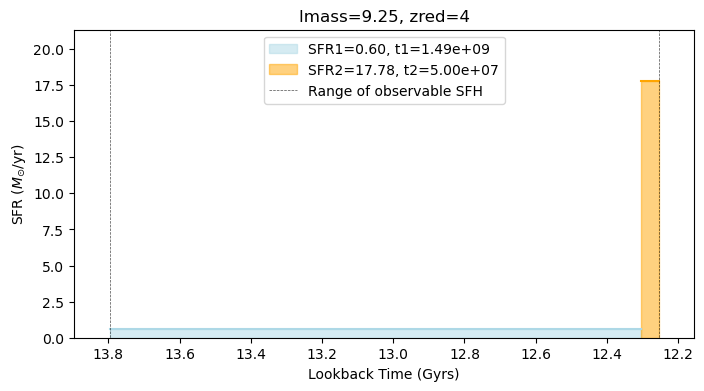

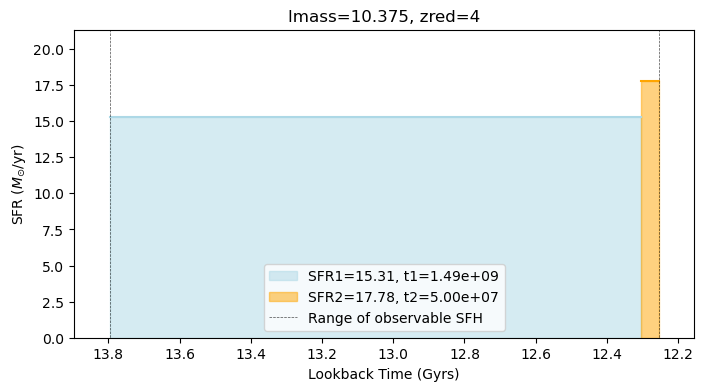

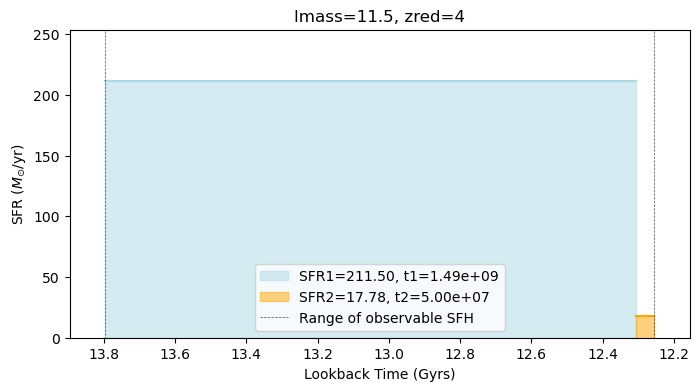

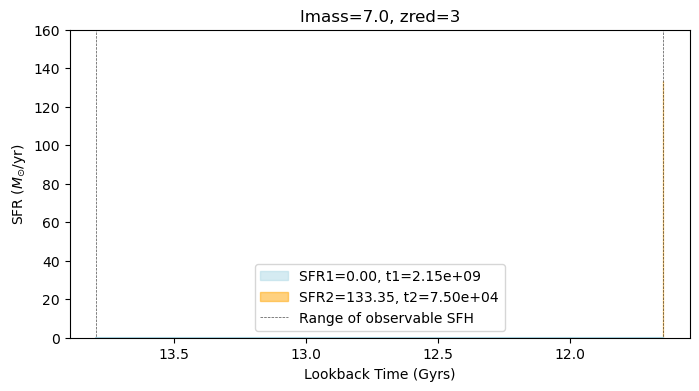

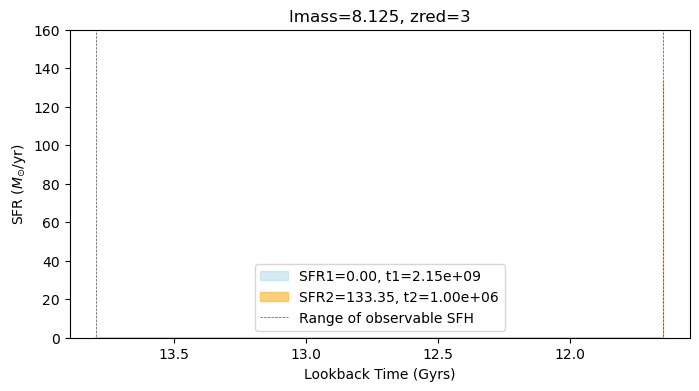

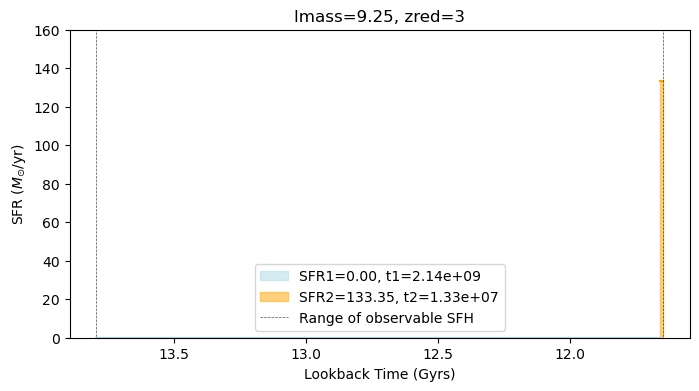

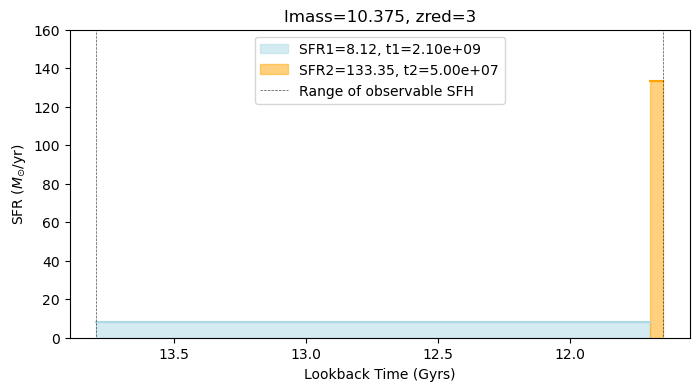

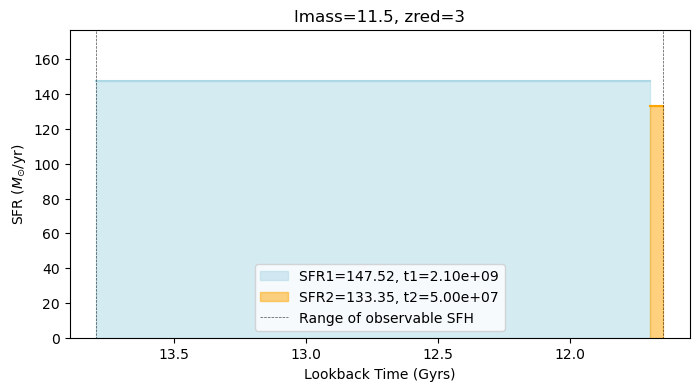

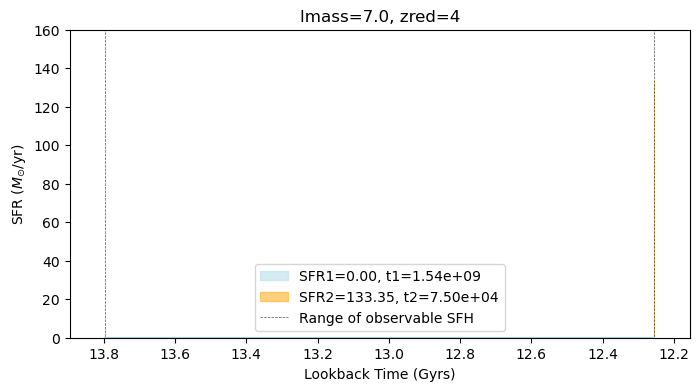

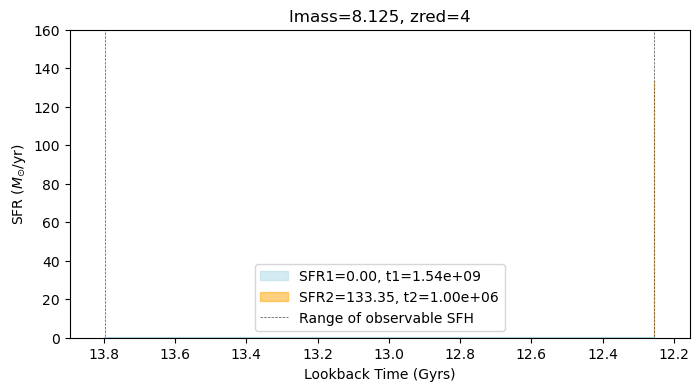

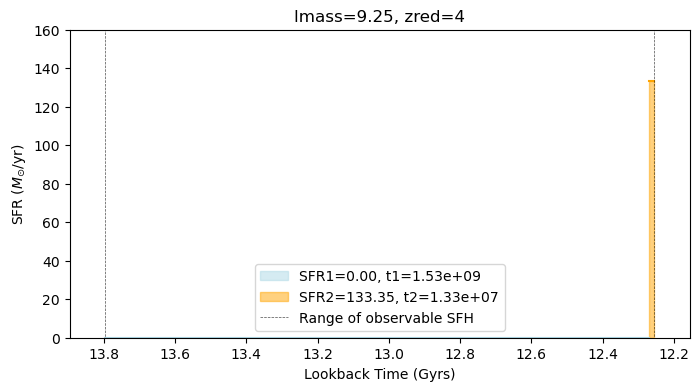

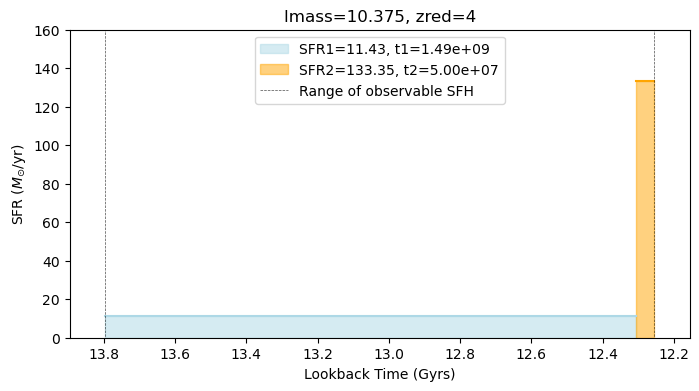

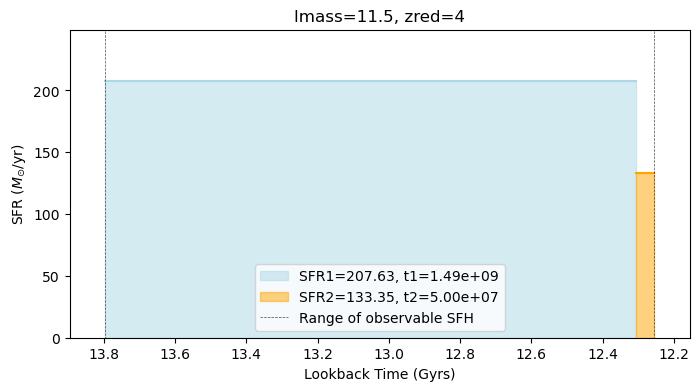

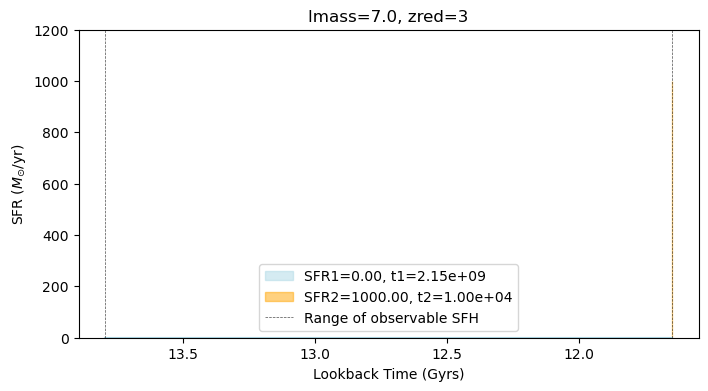

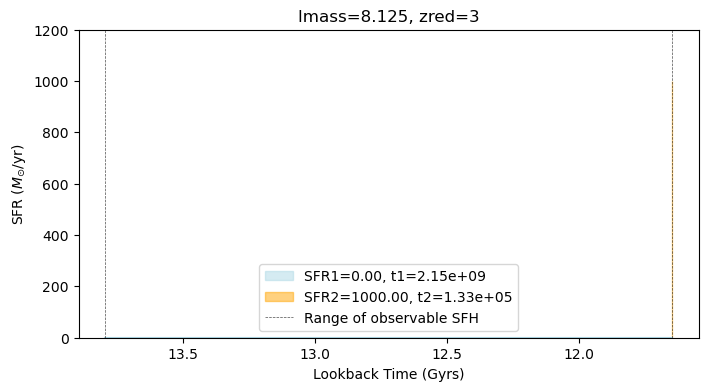

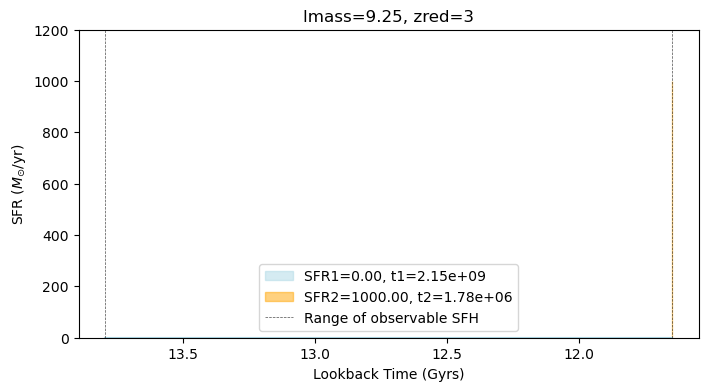

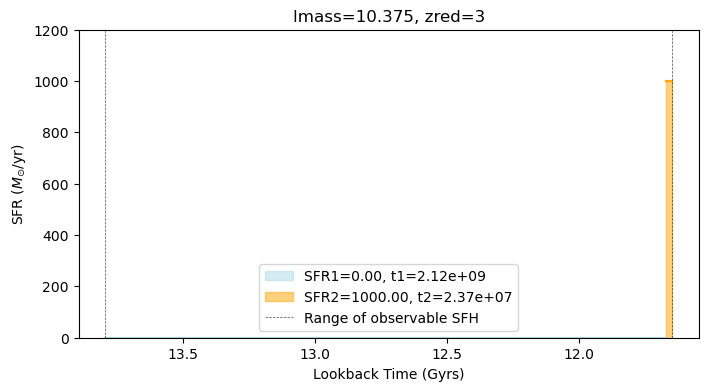

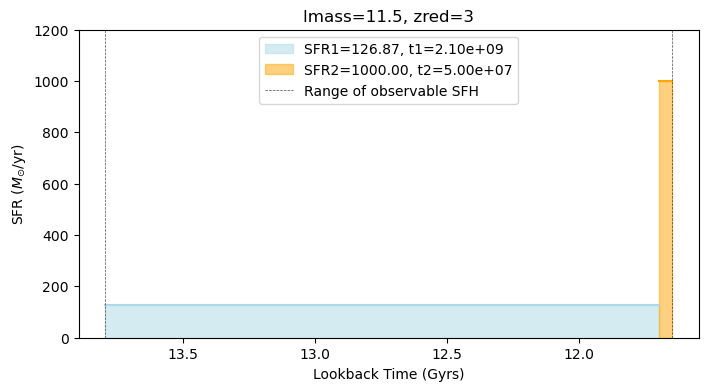

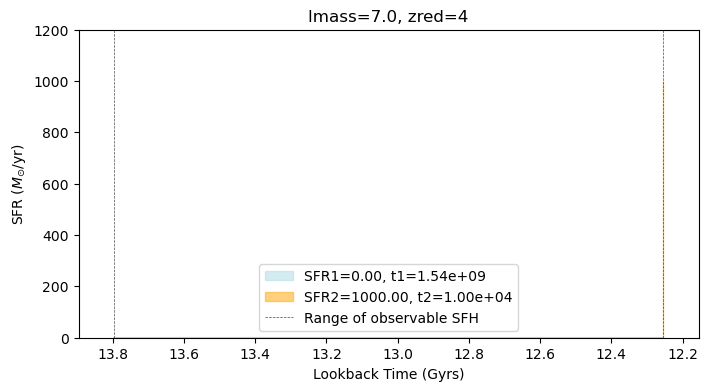

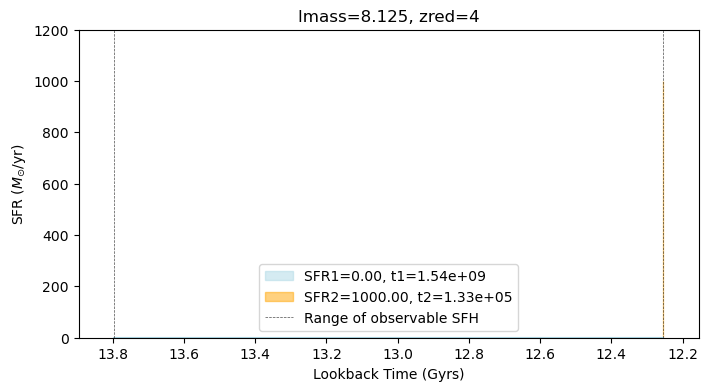

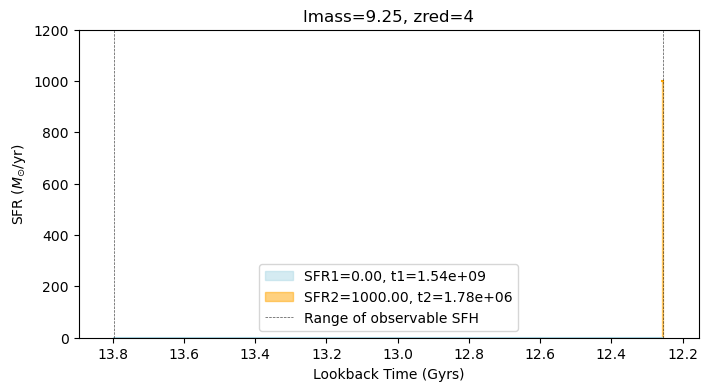

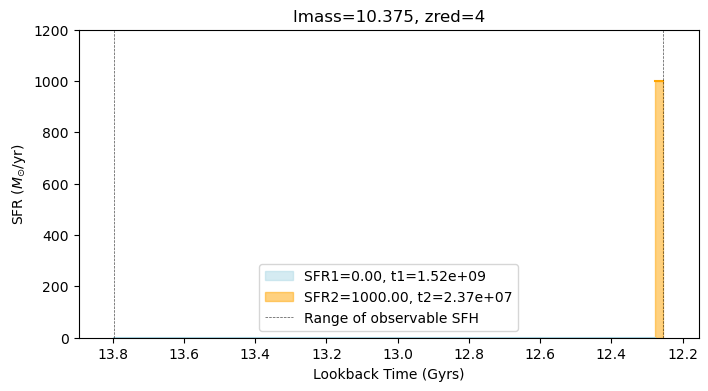

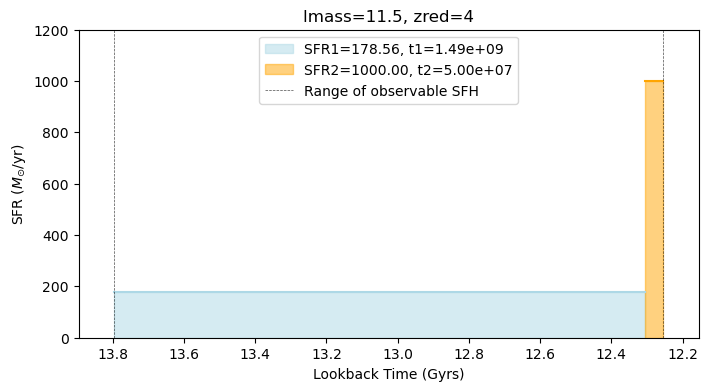

In [21]:
for i_lsfr in range(len(lsfrs)):
    for i_z in range(len(zs[-2:])):
        for i_lmass in range(len(lmasses)):
            
            getSfrPlot(data_grid[i_lmass,i_z,i_lsfr,:], data_params[i_lmass,i_z,i_lsfr,:])